### 1. Read data into dataframes

In [22]:
import pandas as pd

data = pd.read_csv('../data/data_title_fully_processed.csv')
titles = data['processed_title']
data = pd.read_csv('../data/date_popularity_processed.csv')
popularity = data['popularity']

### 2. Process text

In [23]:
title_tokens = []
for title in titles:
    title_tokens.append((str(title)).split(' '))

title_tokens[:10]

[['meet', 'founder', 'blog', 'revolution'],
 ['averting', 'climate', 'crisis'],
 ['simplicity', 'sell'],
 ['chemical', 'scum', 'dream', 'distant', 'quasar'],
 ['wish', 'global', 'day', 'film'],
 ['love', 'cheat'],
 ['happiness', 'body', 'soul'],
 ['life', 'purpose'],
 ['rebuild', 'broken', 'state'],
 ['school', 'kill', 'creativity']]

### 3. Run apriori association rule mining

In [24]:
from association_functions import extract_rules

rules, _, _, _ = extract_rules(title_tokens, 0.001, 0.1)
len(rules)

116

### 4. Tune hyperparameters

##### With confidence threshold of 0, no rules are found past a support threshold of 0.04.

In [25]:
rules, _, _, _ = extract_rules(title_tokens, 0.04, 0.0)
len(rules)

0

##### Examine behavior of rule count wrt. support thresholds between (0, 0.04) at two different confidence thresholds.

In [26]:
import numpy as np
import matplotlib.pyplot as plot

support = np.arange(0.001, 0.04, 0.001)
rules0 = np.empty_like(support)
rules1 = np.empty_like(support)
for i, sup in enumerate(support):
    rules0[i] = len(extract_rules(title_tokens, sup, 0)[0])
    rules1[i] = len(extract_rules(title_tokens, sup, 0.1)[0])

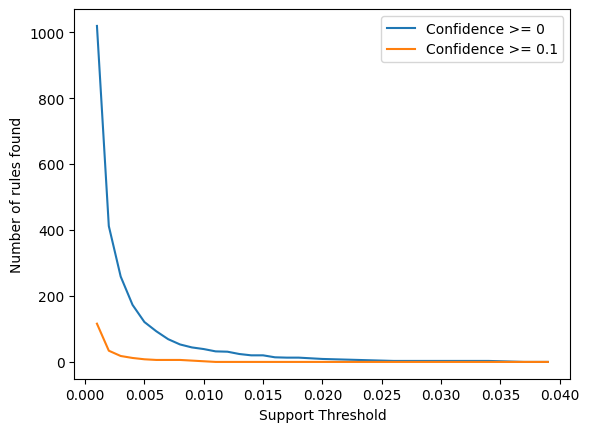

In [27]:
plot.plot(support, rules0, label='Confidence >= 0')
plot.plot(support, rules1, label='Confidence >= 0.1')
plot.xlabel('Support Threshold')
plot.ylabel('Number of rules found')
plot.legend()

##### By visual inspection, support threshold elbow appears to occur between 0.0025 and 0.0075.
##### Examine behavior of rule count wrt. confidence thresholds at support thresholds between 0.0025 and 0.0075.

In [28]:
conf = np.arange(0.0, 0.2, 0.001)
rules25 = np.empty_like(conf)
rules50 = np.empty_like(conf)
rules75 = np.empty_like(conf)
for i, cf in enumerate(conf):
    rules25[i] = len(extract_rules(title_tokens, 0.0025, cf)[0])
    rules50[i] = len(extract_rules(title_tokens, 0.005, cf)[0])
    rules75[i] = len(extract_rules(title_tokens, 0.0075, cf)[0])

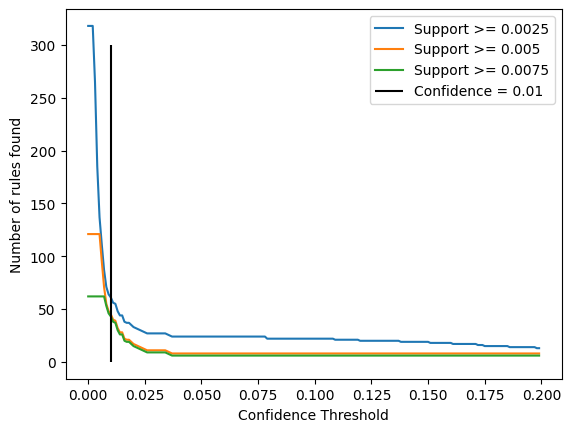

In [29]:
cthresh = 0.01

plot.plot(conf, rules25, label='Support >= 0.0025')
plot.plot(conf, rules50, label='Support >= 0.005')
plot.plot(conf, rules75, label='Support >= 0.0075')
plot.vlines(cthresh, 0, 300, colors='black', label=f'Confidence = {cthresh}')

plot.xlabel('Confidence Threshold')
plot.ylabel('Number of rules found')
plot.legend()

##### At this interval of support thresholds, defining the confidence threshold at 0.01 prevents rule count from blowing up.
##### Examine behavior of rule count wrt. support thresholds at confidence threshold of 0.01

In [30]:
rules01 = np.empty_like(support)
for i, sup in enumerate(support):
    rules01[i] = len(extract_rules(title_tokens, sup, cthresh)[0])

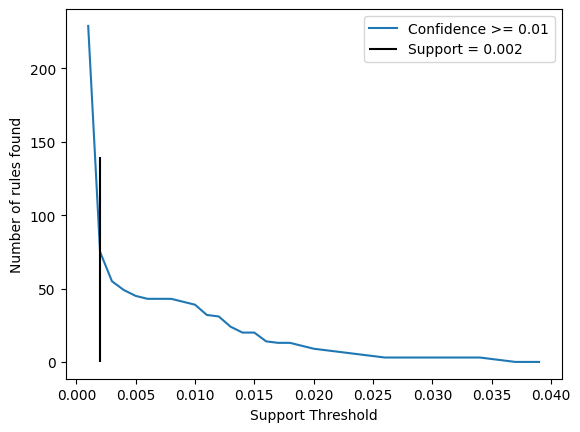

In [31]:
sthresh = 0.002
plot.plot(support, rules01, label='Confidence >= 0.01')
plot.vlines(sthresh, 0, 140, colors='black', label=f'Support = {sthresh}')

plot.xlabel('Support Threshold')
plot.ylabel('Number of rules found')
plot.legend()

##### At a confidence threshold of 0.01, defining the support threshold at 0.002 prevents rule count from blowing up.

### 5. Run apriori association rule mining with tuned hyperparameters

In [32]:
rules, support, confidence, lift = extract_rules(title_tokens, sthresh, cthresh)
df = pd.DataFrame({'Rules': rules, 'Support': support, 'Confidence': confidence})
len(df)

75

##### Sort sets by highest support

In [33]:
df.sort_values(by=['Support'], ascending=False)

,Rules,Support,Confidence
17,[life],0.036583,0.036583
36,[world],0.035518,0.035518
32,[us],0.034097,0.034097
9,[future],0.025573,0.025573
20,[make],0.024507,0.024507
...,...,...,...
62,"[think, like]",0.002309,0.295455
65,"[need, world]",0.002309,0.115044
66,"[world, need]",0.002309,0.065000
41,"[brief, history]",0.002131,0.923077


##### Sort sets by highest confidence

In [34]:
df.sort_values(by=['Confidence'], ascending=False)

,Rules,Support,Confidence
41,"[brief, history]",0.002131,0.923077
69,"[riddle, solve]",0.009767,0.901639
57,"[let, us]",0.010123,0.826087
54,"[mental, health]",0.002486,0.777778
70,"[solve, riddle]",0.009767,0.705128
...,...,...,...
26,[riddle],0.010833,0.010833
19,[love],0.010655,0.010655
12,[health],0.010478,0.010478
8,[design],0.010478,0.010478


##### What if we want to exclude single word clusters? Observe that the lowest confidence of a two-word cluster with our current metrics is 0.108696, while the highest confidence of a one-word cluster is 0.036583. Setting a minimum confidence threshold of 0.1 would eliminate all one-word clusters.

In [35]:
rules, support, confidence, lift = extract_rules(title_tokens, sthresh, 0.1)
df = pd.DataFrame({'Rules': rules, 'Support': support, 'Confidence': confidence})
df.sort_values(by=['Support'], ascending=False)

,Rules,Support,Confidence
19,"[us, let]",0.010123,0.296875
18,"[let, us]",0.010123,0.826087
29,"[solve, riddle]",0.009767,0.705128
28,"[riddle, solve]",0.009767,0.901639
8,"[change, climate]",0.008879,0.416667
9,"[climate, change]",0.008879,0.485437
0,"[3, way]",0.005150,0.391892
1,"[way, 3]",0.005150,0.233871
32,"[teach, us]",0.004085,0.460000
27,"[way, new]",0.004085,0.185484


##### It is intuitive that larger word clusters will have lower support values than one-word clusters. With a much higher confidence threshold, we can reduce the support threshold to 0.001 without producing too many clusters.

In [36]:
rules, support, confidence, lift = extract_rules(title_tokens, 0.001, 0.1)
df = pd.DataFrame({'Rules': rules, 'Support': support, 'Confidence': confidence})
df.sort_values(by=['Support'], ascending=False)

,Rules,Support,Confidence
81,"[let, us]",0.010123,0.826087
82,"[us, let]",0.010123,0.296875
106,"[solve, riddle]",0.009767,0.705128
105,"[riddle, solve]",0.009767,0.901639
27,"[climate, change]",0.008879,0.485437
...,...,...,...
60,"[system, fix]",0.001066,0.162162
61,"[fix, way]",0.001066,0.193548
74,"[ugly, history]",0.001066,0.857143
75,"[v, history]",0.001066,0.222222
